<h1>Procesamiento de datos a gran escala</h1>

<p><strong>Objetivo: </strong> El objetivo de este cuaderno es aplicar el algoritmo de clustering a un conjunto de datos sencillos. </p>

<h2>Clustering</h2>

<h2>Indice</h2>

<div class="alert alert-block alert-info" style="margin-top: 20px">
<ul>
  <li>Cargar los Datos</li>
  <li>Aplicando Algortimo K-Medias</li>
</ul>

Tiempo estimado: <strong>10 min</strong>

</div>
<hr>

<h3>Cargar los datos</h3>

Para este ejercicio se estará utilizando el conjunto de datos Iris, la cual es una fuente en línea en formato CSV (valores separados por coma).
<p> Este set de datos posee diferentes medidas sobre la planta Iris y es famosamente utilizado como ejemplo en analítica de datos:
  </p>
Se utiliza este conjunto para ejemplificar la creación de clusters:

<ul>
  <li>descripción: <a href="https://archive.ics.uci.edu/ml/datasets/Iris" target="_blank">https://archive.ics.uci.edu/ml/datasets/Iris</a></li>
  <li>fuente de datos: <a href="https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data" target="_blank">https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data</a></li>
    <li>tipo de datos: csv</li>

Se va a utilizar la librería Pandas de Python para realizar la lectura de archivos. Se cargan los datos, se agregan cabeceras y se muestra el resultado:

In [27]:
import sys
!{sys.executable} -m pip install wget
import wget
!pip install findspark
import findspark
findspark.init()
from pyspark.sql.types import StructType, StructField, FloatType, StringType

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.functions import col, when, count, isnan

from pyspark.ml.feature import VectorAssembler


Defaulting to user installation because normal site-packages is not writeable


In [16]:
# SE CREA UNA SESION PARA HACER EL CONTEXTO DE PROCESAMIENTO DESDE MI CUOTA DEL CLUSTER HPC

# SE LEVANTA LA CONFIGURACION DE MI CUOTA

configura = SparkConf().set("spark.scheduler.mode", "FAIR")
configura.setAppName("HPC_Gomez")

spark05 = SparkSession.builder.config(conf=configura).getOrCreate()
SQLContext(sparkContext=spark05.sparkContext, sparkSession=spark05)

contextoSpark05 = spark05.sparkContext.getOrCreate()

print("Sesion CLuster HJPC: Gomez_25_08_2025")

spark05

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/05 07:59:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Sesion CLuster HJPC: Gomez_25_08_2025


In [17]:
# Leer datos desde archivo CSV

url_path = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
local_path ="iris.data"
wget.download(url_path,local_path)

schema = StructType([StructField("sepal_length", FloatType(), True),
                     StructField("sepal_width",  FloatType(), True),
                     StructField("petal_length", FloatType(), True),
                     StructField("petal_width",  FloatType(), True),
                     StructField("Species",        StringType(), True)])


df00 = spark05.read.format("csv").option("header", "false").schema(schema).load(local_path)

df00.show(5)

-1 / unknown+------------+-----------+------------+-----------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|    Species|
+------------+-----------+------------+-----------+-----------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|
+------------+-----------+------------+-----------+-----------+
only showing top 5 rows



In [18]:
df00.printSchema()

root
 |-- sepal_length: float (nullable = true)
 |-- sepal_width: float (nullable = true)
 |-- petal_length: float (nullable = true)
 |-- petal_width: float (nullable = true)
 |-- Species: string (nullable = true)



In [22]:
df00.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df00.columns]).show()

+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|Species|
+------------+-----------+------------+-----------+-------+
|           0|          0|           0|          0|      0|
+------------+-----------+------------+-----------+-------+




### Aplicar Indexador a Columna "Species"

In [23]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
# StringIndexer Initialization
indexer = StringIndexer(inputCol="Species", outputCol="Species_Indexed")
indexerModel = indexer.fit(df00)

# Transform the DataFrame using the fitted StringIndexer model
indexed_df = indexerModel.transform(df00)
indexed_df.show()

+------------+-----------+------------+-----------+-----------+---------------+
|sepal_length|sepal_width|petal_length|petal_width|    Species|Species_Indexed|
+------------+-----------+------------+-----------+-----------+---------------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|            0.0|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|            0.0|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|            0.0|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|            0.0|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|            0.0|
|         5.4|        3.9|         1.7|        0.4|Iris-setosa|            0.0|
|         4.6|        3.4|         1.4|        0.3|Iris-setosa|            0.0|
|         5.0|        3.4|         1.5|        0.2|Iris-setosa|            0.0|
|         4.4|        2.9|         1.4|        0.2|Iris-setosa|            0.0|
|         4.9|        3.1|         1.5| 

In [24]:
indexed_df.select('Species').distinct().collect()

[Row(Species='Iris-virginica'),
 Row(Species='Iris-setosa'),
 Row(Species='Iris-versicolor')]

<h3>Aplicar Algortimo K-Medias</h3>

Seleccione solo las columnas numéricas:

In [25]:
df_kmeans = df00[["sepal_length","sepal_width","petal_length","petal_width"]]
df_kmeans.show(5)

+------------+-----------+------------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|
+------------+-----------+------------+-----------+
|         5.1|        3.5|         1.4|        0.2|
|         4.9|        3.0|         1.4|        0.2|
|         4.7|        3.2|         1.3|        0.2|
|         4.6|        3.1|         1.5|        0.2|
|         5.0|        3.6|         1.4|        0.2|
+------------+-----------+------------+-----------+
only showing top 5 rows



### Formatear los datos usando Vector Assembler en los vectores los cuales serán usados como "features"

In [28]:
assembler = VectorAssembler(inputCols = df_kmeans.columns, outputCol='features')
df_datos = assembler.transform(df00)


### Escalar los datos

In [30]:

from pyspark.ml.feature import StandardScaler

# Suponiendo que 'df_datos' tiene la columna 'features' generada por VectorAssembler
escalador = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)

# Compute summary statistics by fitting the StandardScaler
modeloEscalado = escalador.fit(df_datos)

# Normalize each feature to have unit standard deviation.
df_datos = modeloEscalado.transform(df_datos)

df_datos.show(5)

+------------+-----------+------------+-----------+-----------+--------------------+--------------------+
|sepal_length|sepal_width|petal_length|petal_width|    Species|            features|      scaledFeatures|
+------------+-----------+------------+-----------+-----------+--------------------+--------------------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|[5.09999990463256...|[-0.8976740030829...|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|[4.90000009536743...|[-1.1392003814247...|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|[4.69999980926513...|[-1.3807273356108...|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|[4.59999990463256...|[-1.5014905247816...|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|[5.0,3.5999999046...|[-1.0184371922538...|
+------------+-----------+------------+-----------+-----------+--------------------+--------------------+
only showing top 5 rows



### Encontrar el número de clusters usando Silhouette Score

In [31]:
#Importing the model
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_score=[]

evaluador = ClusteringEvaluator(predictionCol='prediction',
                                featuresCol='scaledFeatures', \
                                metricName='silhouette', 
                                distanceMeasure='squaredEuclidean')

for i in range(2,10):
    kmeans=KMeans(featuresCol='scaledFeatures', k=i)
    KMeans_fit=kmeans.fit(df_datos)
    output = KMeans_fit.transform(df_datos)   
    score = evaluador.evaluate(output)   
    silhouette_score.append(score)
    print('Silhouette Score for k =',i,'is',score)

25/11/05 08:03:26 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Silhouette Score for k = 2 is 0.7714149115179747
Silhouette Score for k = 3 is 0.6535875461939233
Silhouette Score for k = 4 is 0.5825498201159433
Silhouette Score for k = 5 is 0.4931243162694247
Silhouette Score for k = 6 is 0.44074334795591064
Silhouette Score for k = 7 is 0.4606032395773778
Silhouette Score for k = 8 is 0.5226390895638889
Silhouette Score for k = 9 is 0.5141219188555181


### Visualización de silhouette scores

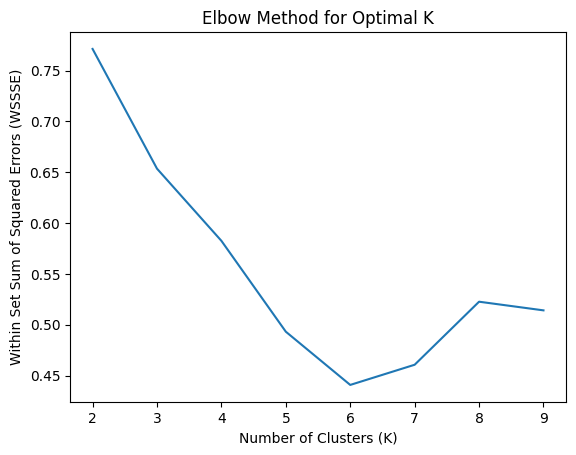

In [32]:
import matplotlib.pyplot as plt

plt.plot(range(2,10),silhouette_score)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within Set Sum of Squared Errors (WSSSE)')
plt.title('Elbow Method for Optimal K')
plt.show()

¿Cúal k seleccionar? ¿Son satisfactorios los resultados de las diferentes k? 
- Se selecciona k=3 (¿porqué?)
- Compare los resultados para k=4, k=6, k=8

### Entrenar el modelo

In [38]:
kmeans = KMeans(k=3, featuresCol="scaledFeatures", predictionCol="cluster")
kmeans_model = kmeans.fit(df_datos)



### Evaluar el modelo k=3 Within Set Sum of Squared Errors (WSSSE) metric

In [41]:
output = KMeans_fit.transform(df_datos)
wssse = evaluador.evaluate(output)
print(f"Within Set Sum of Squared Errors (WSSSE) = {wssse}")

Within Set Sum of Squared Errors (WSSSE) = 0.5141219188555181


### Visualizar los Datos

['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'Species', 'features', 'scaledFeatures', 'cluster']


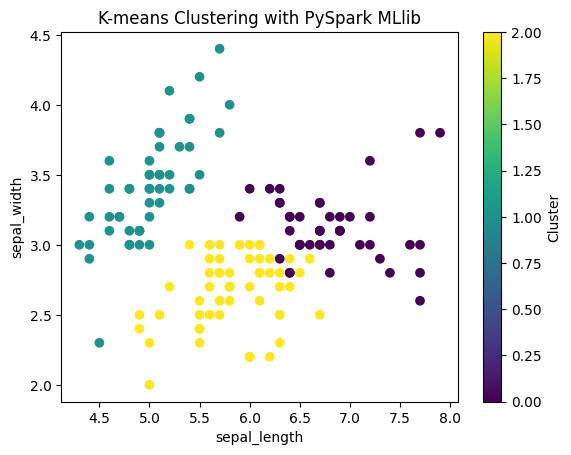

In [43]:
# Transformar los datos con el modelo entrenado
output = kmeans_model.transform(df_datos)

# Verificar que la columna 'cluster' exista
print(output.columns)  # Debe incluir 'cluster'

# Convertir a Pandas para visualización
clustered_data_pd = output.toPandas()

# Visualización con matplotlib
import matplotlib.pyplot as plt

plt.scatter(clustered_data_pd["sepal_length"], clustered_data_pd["sepal_width"], 
            c=clustered_data_pd["cluster"], cmap='viridis')
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")
plt.title("K-means Clustering with PySpark MLlib")
plt.colorbar(label="Cluster")
plt.show()


In [44]:
df_datos.columns

['sepal_length',
 'sepal_width',
 'petal_length',
 'petal_width',
 'Species',
 'features',
 'scaledFeatures']

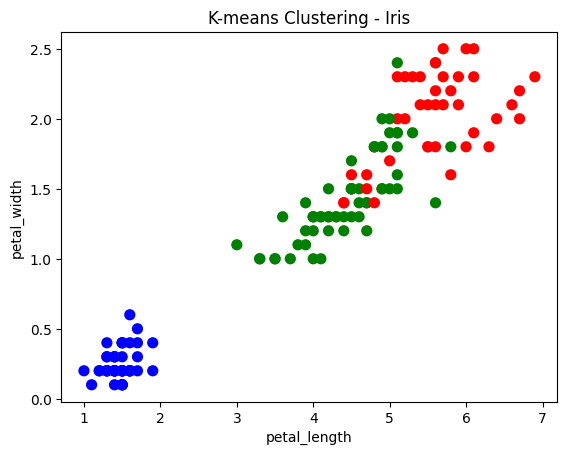

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Convertir a Pandas
clustered_data_pd = output.toPandas()

# Definir colores (suficientes para tus clusters)
color = np.array(['red','blue','green','cyan','yellow'])

# Graficar
plt.scatter(
    x=clustered_data_pd["petal_length"], 
    y=clustered_data_pd["petal_width"], 
    c=color[clustered_data_pd["cluster"]], 
    s=50
)
plt.xlabel("petal_length")
plt.ylabel("petal_width")
plt.title("K-means Clustering - Iris")
plt.show()



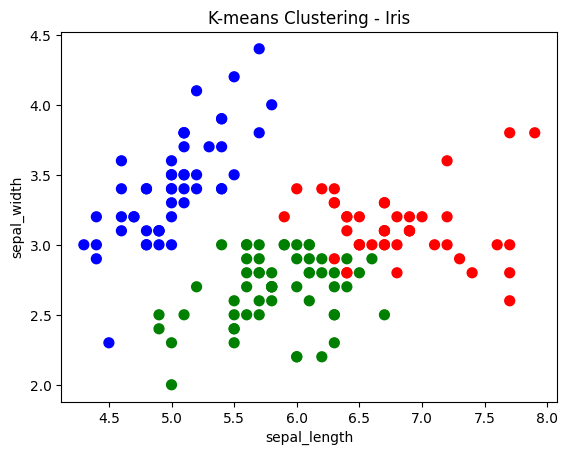

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Convertir el DataFrame PySpark a Pandas
clustered_data_pd = output.toPandas()

# Definir colores para los clusters (suficientes para tus k clusters)
color = np.array(['red', 'blue', 'green', 'cyan', 'yellow'])

# Graficar usando los ejes de sépalos
plt.scatter(
    x=clustered_data_pd["sepal_length"],
    y=clustered_data_pd["sepal_width"],
    c=color[clustered_data_pd["cluster"]],
    s=50
)
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")
plt.title("K-means Clustering - Iris")
plt.show()


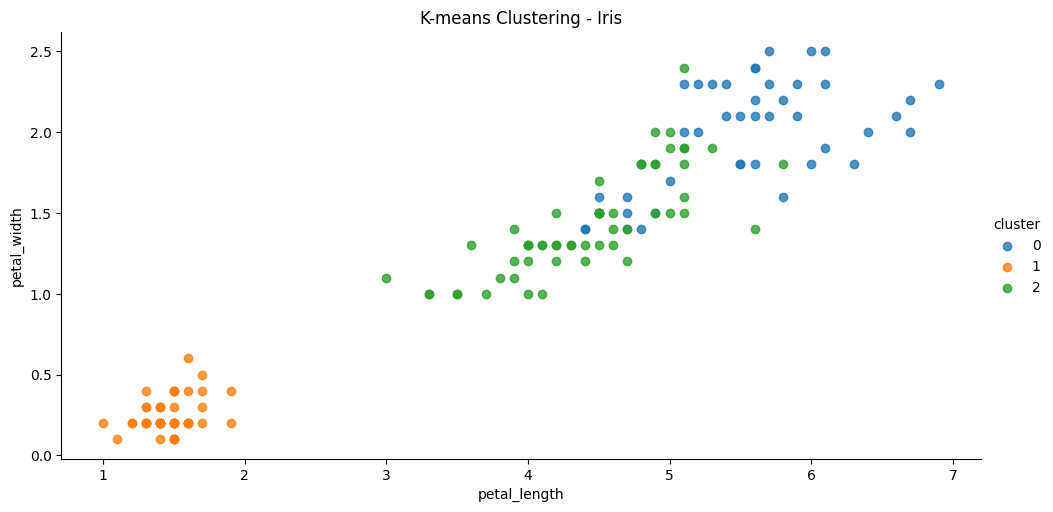

In [51]:
import seaborn as sns
import pandas as pd

# Convertir PySpark DataFrame a Pandas
clustered_data_pd = output.toPandas()

# Graficar con Seaborn
sns.lmplot(
    x='petal_length',
    y='petal_width',
    data=clustered_data_pd,
    hue='cluster',       # nombre de la columna con clusters en PySpark
    fit_reg=False,
    height=5,
    aspect=2
)
plt.title("K-means Clustering - Iris")
plt.show()


### Modelos para K=4, k=6, k=8

#### K=4 

In [52]:
# Crear modelo KMeans
kmeans4 = KMeans(k=4, featuresCol="scaledFeatures", predictionCol="cluster")
kmeans_model4 = kmeans4.fit(df_datos)

# Transformar los datos
output4 = kmeans_model4.transform(df_datos)

# Evaluador WSSSE (Silhouette con métrica de distancia euclidiana)
evaluador = ClusteringEvaluator(featuresCol="scaledFeatures", predictionCol="cluster", metricName="silhouette")
wssse4 = evaluador.evaluate(output4)

print(f"WSSSE para k=4 = {wssse4}")

WSSSE para k=4 = 0.5825498201159433


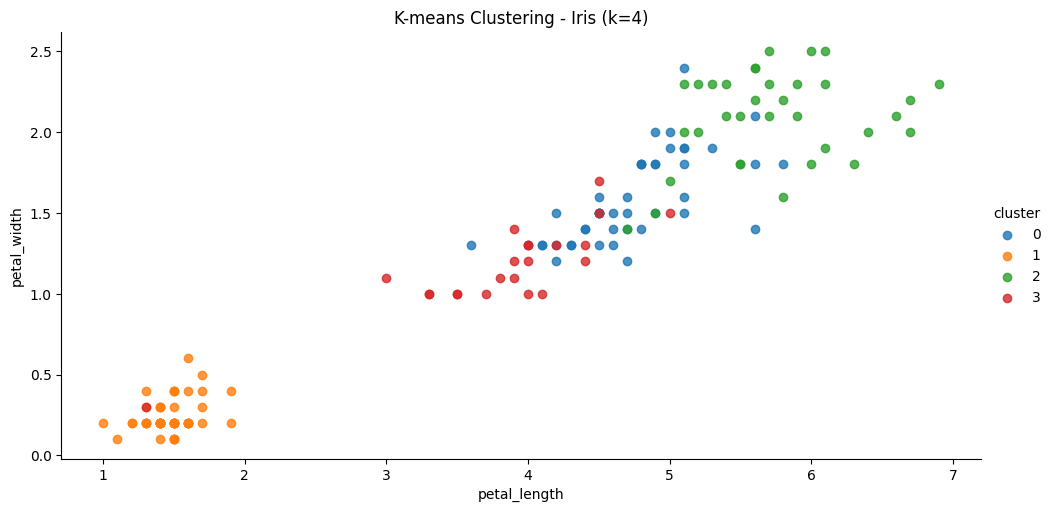

In [55]:
# Convertir el DataFrame de PySpark a Pandas
clustered_data_pd4 = output4.toPandas()

# Graficar con Seaborn
sns.lmplot(
    x='petal_length',
    y='petal_width',
    data=clustered_data_pd4,
    hue='cluster',       # columna generada por KMeans
    fit_reg=False,
    height=5,
    aspect=2
)
plt.title("K-means Clustering - Iris (k=4)")
plt.show()

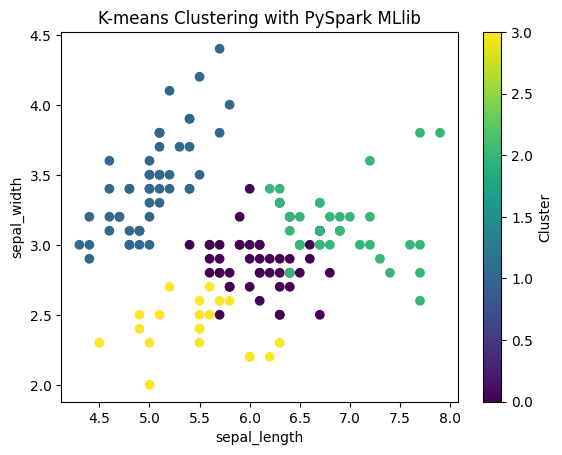

In [59]:
# Convertir a Pandas para visualización
clustered_data_pd = output4.toPandas()

# Visualización con matplotlib
import matplotlib.pyplot as plt

plt.scatter(clustered_data_pd["sepal_length"], clustered_data_pd["sepal_width"], 
            c=clustered_data_pd["cluster"], cmap='viridis')
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")
plt.title("K-means Clustering with PySpark MLlib")
plt.colorbar(label="Cluster")
plt.show()

#### K=6

In [53]:
# Crear modelo KMeans
kmeans6 = KMeans(k=6, featuresCol="scaledFeatures", predictionCol="cluster")
kmeans_model6 = kmeans6.fit(df_datos)

# Transformar los datos
output6 = kmeans_model6.transform(df_datos)

# Evaluar
wssse6 = evaluador.evaluate(output6)
print(f"WSSSE para k=6 = {wssse6}")


WSSSE para k=6 = 0.44074334795591064


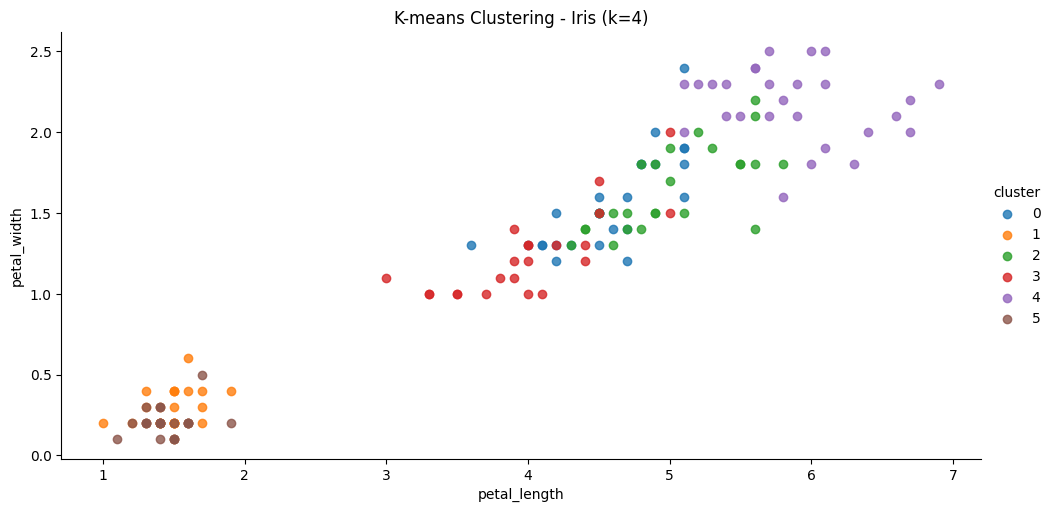

In [58]:
# Convertir el DataFrame de PySpark a Pandas
clustered_data_pd6 = output6.toPandas()

# Graficar con Seaborn
sns.lmplot(
    x='petal_length',
    y='petal_width',
    data=clustered_data_pd4,
    hue='cluster',       # columna generada por KMeans
    fit_reg=False,
    height=5,
    aspect=2
)
plt.title("K-means Clustering - Iris (k=4)")
plt.show()

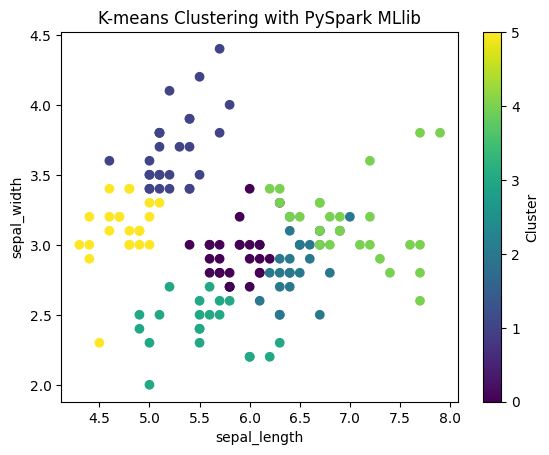

In [60]:
# Convertir a Pandas para visualización
clustered_data_pd = output6.toPandas()

# Visualización con matplotlib
import matplotlib.pyplot as plt

plt.scatter(clustered_data_pd["sepal_length"], clustered_data_pd["sepal_width"], 
            c=clustered_data_pd["cluster"], cmap='viridis')
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")
plt.title("K-means Clustering with PySpark MLlib")
plt.colorbar(label="Cluster")
plt.show()

#### K=8

In [54]:
# Crear modelo KMeans
kmeans8 = KMeans(k=8, featuresCol="scaledFeatures", predictionCol="cluster")
kmeans_model8 = kmeans8.fit(df_datos)

# Transformar los datos
output8 = kmeans_model8.transform(df_datos)

# Evaluar
wssse8 = evaluador.evaluate(output8)
print(f"WSSSE para k=8 = {wssse8}")


WSSSE para k=8 = 0.5226390895638889


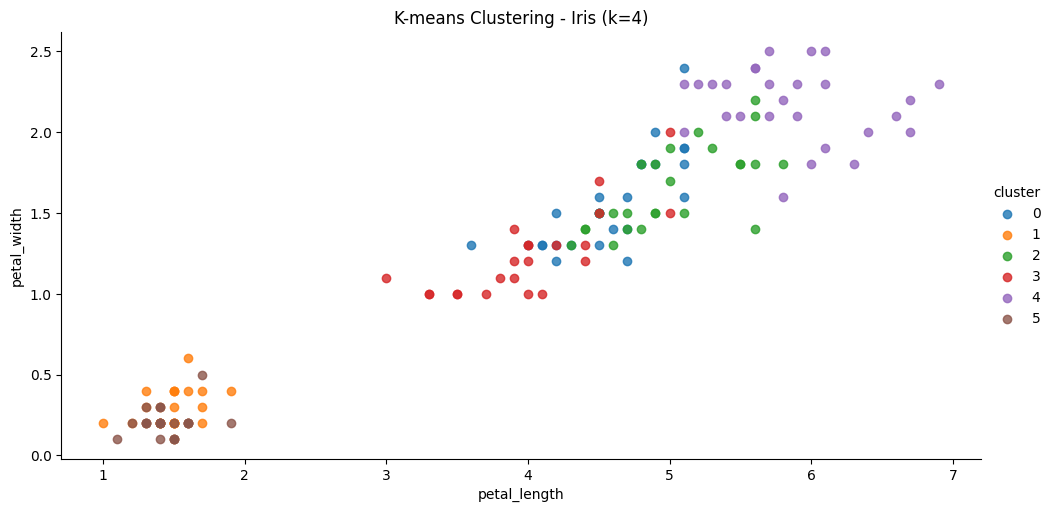

In [57]:
# Convertir el DataFrame de PySpark a Pandas
clustered_data_pd8 = output8.toPandas()

# Graficar con Seaborn
sns.lmplot(
    x='petal_length',
    y='petal_width',
    data=clustered_data_pd4,
    hue='cluster',       # columna generada por KMeans
    fit_reg=False,
    height=5,
    aspect=2
)
plt.title("K-means Clustering - Iris (k=4)")
plt.show()

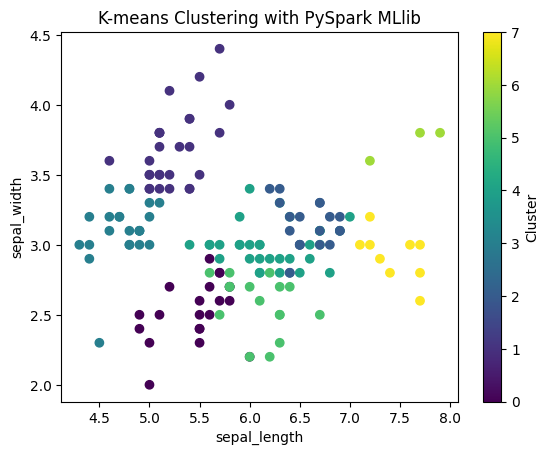

In [61]:
# Convertir a Pandas para visualización
clustered_data_pd = output8.toPandas()

# Visualización con matplotlib
import matplotlib.pyplot as plt

plt.scatter(clustered_data_pd["sepal_length"], clustered_data_pd["sepal_width"], 
            c=clustered_data_pd["cluster"], cmap='viridis')
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")
plt.title("K-means Clustering with PySpark MLlib")
plt.colorbar(label="Cluster")
plt.show()

### Análisis

Al observar los gráficos y los resultados del método del codo, se nota que la estructura del dataset Iris se presta a distintas interpretaciones según el valor de k. Con k=3, los clusters capturan bien las tres especies principales y la dispersión interna de cada grupo es aceptable, aunque algunos puntos más alejados sugieren que podrían existir subvariantes dentro de las especies.

Al considerar k=4, estas subvariantes se separan en clusters distintos, lo que genera grupos más compactos y con mayor separación relativa entre ellos. Esto permite ver con más detalle la variabilidad interna de las especies, especialmente en las más parecidas como versicolor y virginica.

Cuando se incrementa k a 6 u 8, los clusters empiezan a fragmentarse excesivamente. Aunque la dispersión interna disminuye, la distancia entre clusters también se reduce, lo que provoca que muchos grupos no representen diferencias biológicas reales y que la interpretación de los clusters pierda sentido.

### Conclusion

- La elección de k=3 es adecuada porque refleja la estructura real del dataset Iris, identificando correctamente las tres especies principales y manteniendo una separación clara entre los clusters.
- Valores de k mayores producen clusters artificiales que fragmentan los grupos naturales, reduciendo la interpretación biológica y dificultando el análisis de los datos.